### Comparison of real and modeled distributions

Script to perform a comparison of the output of all simulations with real-world GTD values

In [25]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
from scipy.stats import ks_2samp
import regex as re

In [2]:
gate_gtd = pd.read_stata('./real_data/GATE_GTD_Israel_monthly_data_ext.dta')
gate_gtd.head()

year  month  concil  repress  concdisc  concindisc  reprdisc  reprindisc  \
0  1988.0    1.0     2.0     18.0       0.0         2.0       4.0        14.0   
1  1989.0    1.0     3.0      1.0       0.0         3.0       0.0         1.0   
2  1990.0    1.0     6.0     21.0       3.0         3.0       8.0        13.0   
3  1991.0    1.0     0.0      5.0       0.0         0.0       0.0         5.0   
4  1992.0    1.0     6.0     21.0       1.0         5.0       5.0        16.0   

      mcount  att93miss  ...  r_atppl3  e_atppl3  s_atppl4  r_atppl4  \
0 1960-09-01        0.0  ...       NaN       NaN       NaN       NaN   
1 1961-09-01        9.0  ...       NaN       NaN       NaN       NaN   
2 1962-09-01       14.0  ...       NaN       NaN       NaN       NaN   
3 1963-09-01        0.0  ...       NaN       NaN       NaN       NaN   
4 1964-09-01        7.0  ...       NaN       NaN       NaN       NaN   

   e_atppl4  att_pal  att_unk  att_palunk  att_tot           _merge  
0       NaN      0.0      0.0         0.0      0.0  master only (1)  
1       NaN      4.0      5.0         9.0     11.0      matched (3)  
2       NaN      9.0      5.0        14.0     14.0      matched (3)  
3       NaN      0.0      0.0         0.0      0.0  master only (1)  
4       NaN      7.0      0.0         7.0      8.0      matched (3)  

[5 rows x 71 columns]

##### Examine real-world recorded attacks

In [3]:
att_dates = gate_gtd[gate_gtd['year'].notna()]
att_dates['attack_date'] = pd.to_datetime(att_dates['year'].astype('int').astype('str') + '-' + att_dates['month'].astype('int').astype('str') + '-01')

att_dates = att_dates.loc[:,('att_palunk','att_pal','att_unk','attack_date')]
att_dates_plt = att_dates.melt(id_vars=['attack_date'])
att_dates_plt.rename(columns={'variable':'actor','value':'attacks'},inplace=True)

/tmp/ipykernel_757/2074339646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_dates['attack_date'] = pd.to_datetime(att_dates['year'].astype('int').astype('str') + '-' + att_dates['month'].astype('int').astype('str') + '-01')


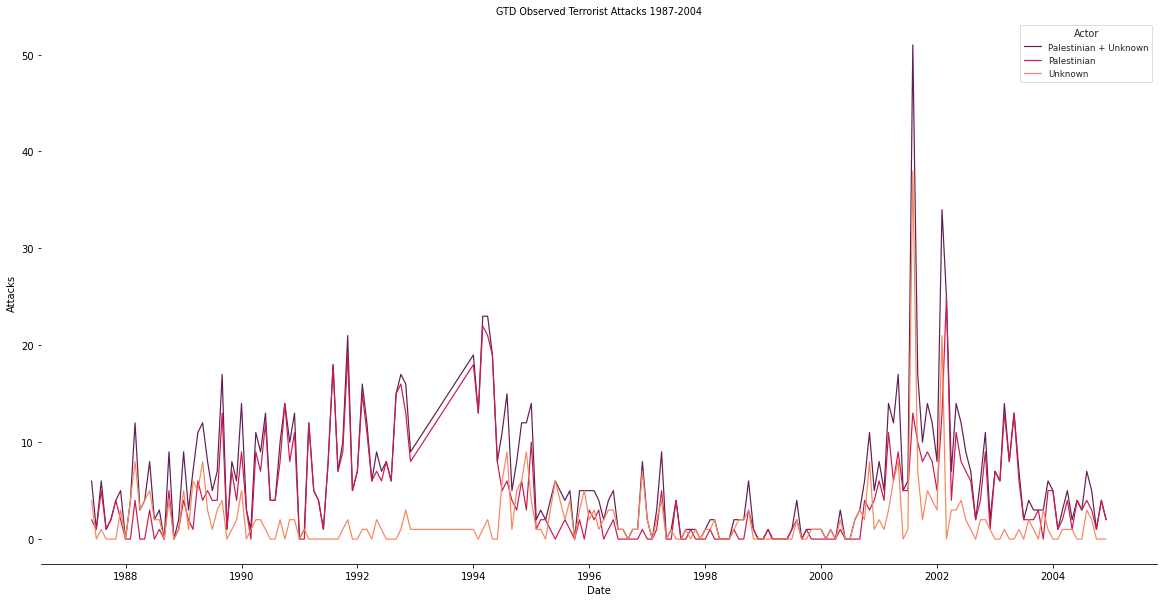

In [4]:
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.set_style('white')
sns.despine(left=True)
sns.set_context('paper')

sns.lineplot(data=att_dates_plt, x="attack_date", y="attacks", ax=ax, hue='actor',palette='rocket')
ax.set(ylabel="Attacks", xlabel="Date", title="GTD Observed Terrorist Attacks 1987-2004")
ax.legend(title="Actor", labels=['Palestinian + Unknown','Palestinian','Unknown'])

##### Examine real-world government actions

In [5]:
actions_df = gate_gtd[gate_gtd['year'].notna()]
actions_df['month_date'] = pd.to_datetime(actions_df['year'].astype('int').astype('str') + '-' + actions_df['month'].astype('int').astype('str') + '-01')
actions_df = actions_df.loc[:,('month_date','concil','repress','concdisc','concindisc','reprdisc','reprindisc')]
actions_df_plt = actions_df.melt(id_vars=['month_date'])
actions_df_plt.rename(columns={'variable':'action_type','value':'actions'},inplace=True)

/tmp/ipykernel_757/2061595547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_df['month_date'] = pd.to_datetime(actions_df['year'].astype('int').astype('str') + '-' + actions_df['month'].astype('int').astype('str') + '-01')


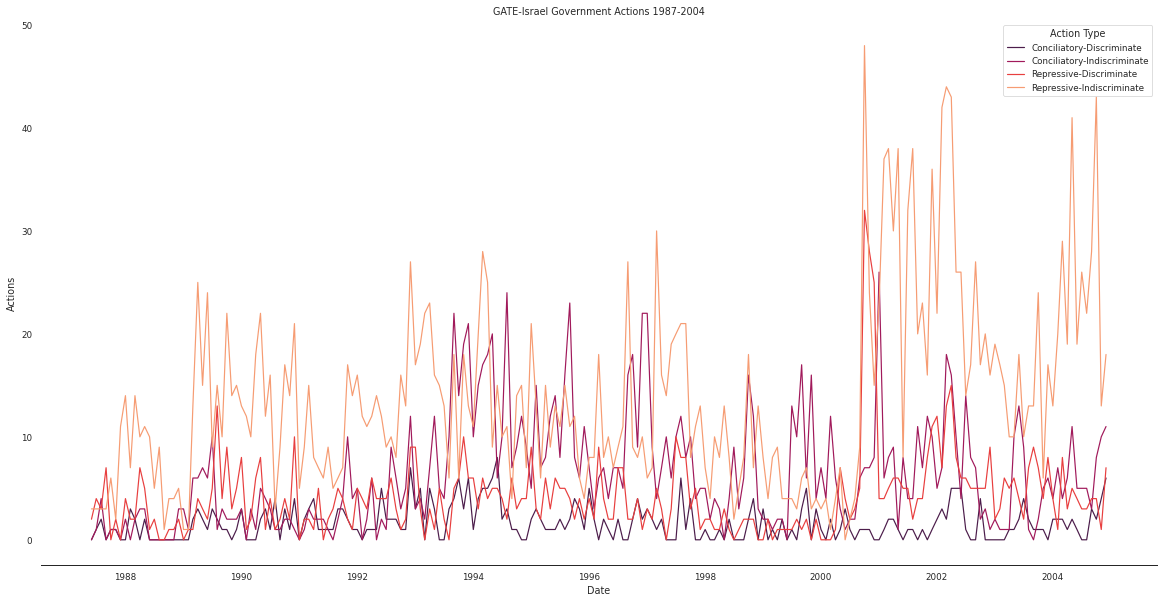

In [6]:
f, ax = plt.subplots(1,1,figsize=(20,10))
sns.set_style('white')
sns.despine(left=True)
sns.set_context('paper')

sns.lineplot(data=actions_df_plt[~actions_df_plt['action_type'].isin(['concil','repress'])], x="month_date", \
    y="actions", ax=ax, hue='action_type',palette='rocket')
ax.set(ylabel="Actions", xlabel="Date", title="GATE-Israel Government Actions 1987-2004")
ax.legend(title="Action Type",labels=['Conciliatory-Discriminate','Conciliatory-Indiscriminate','Repressive-Discriminate','Repressive-Indiscriminate'])

##### Bring in modeled data

In [7]:
full_models_df = pd.read_pickle('./model_output/full_models_df.pkl')
#full_models_df = pd.read_pickle('./../full_models_df.pkl')
param_vals = {'prob_violence':[],'govt_policy':[],'reactive_lvl':[],'discontent':[],'starting_population':[],'steps':[]}
for params in full_models_df['params']:
    #print(params)
    #print(type(params))
    param_dict = ast.literal_eval(params)
    #print(param_dict)
    param_vals['prob_violence'].append(param_dict[0])
    param_vals['govt_policy'].append(param_dict[1])
    param_vals['reactive_lvl'].append(param_dict[2])
    param_vals['discontent'].append(param_dict[3])
    param_vals['starting_population'].append(param_dict[4])
    param_vals['steps'].append(param_dict[5])

In [8]:
print(full_models_df.shape)
full_models_df.head()

(1404000, 3)


num_agents num_attacks                                      params
0        300         166  (0.0001, 'NONE', 'high', 'high', 300, 200)
1        134         167  (0.0001, 'NONE', 'high', 'high', 300, 200)
2        133         167  (0.0001, 'NONE', 'high', 'high', 300, 200)
3        134         167  (0.0001, 'NONE', 'high', 'high', 300, 200)
4        134         167  (0.0001, 'NONE', 'high', 'high', 300, 200)

In [64]:
len(full_models_df['params'].unique())

2700

In [9]:
params_df = pd.DataFrame.from_dict(param_vals)
full_model_results = full_models_df.join(params_df)
print(full_model_results.shape)
full_model_results.head()

(1404000, 9)


num_agents num_attacks                                      params  \
0        300         166  (0.0001, 'NONE', 'high', 'high', 300, 200)   
1        134         167  (0.0001, 'NONE', 'high', 'high', 300, 200)   
2        133         167  (0.0001, 'NONE', 'high', 'high', 300, 200)   
3        134         167  (0.0001, 'NONE', 'high', 'high', 300, 200)   
4        134         167  (0.0001, 'NONE', 'high', 'high', 300, 200)   

   prob_violence govt_policy reactive_lvl discontent  starting_population  \
0         0.0001        NONE         high       high                  300   
1         0.0001        NONE         high       high                  300   
2         0.0001        NONE         high       high                  300   
3         0.0001        NONE         high       high                  300   
4         0.0001        NONE         high       high                  300   

   steps  
0    200  
1    200  
2    200  
3    200  
4    200

In [10]:
# identify models which result in 0 population
zero_fin_pop_params = full_model_results[full_model_results['num_agents'] == 0]['params'].unique()
len(zero_fin_pop_params)

2001

In [11]:
# filter to exclude models which don't have any population by the end
full_potential_models = full_model_results[~full_model_results['params'].isin(zero_fin_pop_params)]
full_potential_models.shape

(348000, 9)

In [17]:
# create count of new attacks each step from cumulative counts in dataset
full_potential_models['new_attacks'] = full_potential_models.groupby('params')['num_attacks'].diff()
full_potential_models_skipfirst = full_potential_models.dropna()
full_potential_models_skipfirst = full_potential_models_skipfirst.reset_index().drop(columns=['index'])
print(full_potential_models_skipfirst.shape)
full_potential_models_skipfirst.head()

(347301, 10)


/tmp/ipykernel_757/2843454003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_potential_models['new_attacks'] = full_potential_models.groupby('params')['num_attacks'].diff()


num_agents num_attacks                                        params  \
0        229          82  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   
1        226          84  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   
2        228          87  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   
3        232          90  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   
4        233          93  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   

   prob_violence govt_policy reactive_lvl discontent  starting_population  \
0         0.0001        NONE      mid-low        mid                  300   
1         0.0001        NONE      mid-low        mid                  300   
2         0.0001        NONE      mid-low        mid                  300   
3         0.0001        NONE      mid-low        mid                  300   
4         0.0001        NONE      mid-low        mid                  300   

   steps new_attacks  
0    300           9  
1    300           2  
2    300           3  
3    300           3  
4    300           3

In [18]:
# create dummy dates to align with true data - considering whole 1988-2004 period
param_combos = full_potential_models_skipfirst['params'].unique()

for param in param_combos:
    param_df = full_potential_models_skipfirst[full_potential_models_skipfirst['params']==param]
    full_potential_models_skipfirst.loc[param_df.index, 'dummy_date'] = pd.date_range(start='01/01/1988',end='09/01/2004',periods=param_df['steps'].mean() - 1)

print(full_potential_models_skipfirst.shape)
full_potential_models_skipfirst.head()

(347301, 11)


num_agents num_attacks                                        params  \
0        229          82  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   
1        226          84  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   
2        228          87  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   
3        232          90  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   
4        233          93  (0.0001, 'NONE', 'mid-low', 'mid', 300, 300)   

   prob_violence govt_policy reactive_lvl discontent  starting_population  \
0         0.0001        NONE      mid-low        mid                  300   
1         0.0001        NONE      mid-low        mid                  300   
2         0.0001        NONE      mid-low        mid                  300   
3         0.0001        NONE      mid-low        mid                  300   
4         0.0001        NONE      mid-low        mid                  300   

   steps new_attacks                    dummy_date  
0    300           9 1988-01-01 00:00:00.000000000  
1    300           2 1988-01-21 10:18:31.409395973  
2    300           3 1988-02-10 20:37:02.818791946  
3    300           3 1988-03-02 06:55:34.228187920  
4    300           3 1988-03-22 17:14:05.637583893

In [20]:
# filter out models which result in no attacks by the equivalent of the last 3 years
final_years_means = full_potential_models_skipfirst[full_potential_models_skipfirst['dummy_date'] >= '01-01-2001'].groupby(['params'])['new_attacks','num_attacks'].sum()
print(final_years_means.shape)
print(final_years_means[final_years_means['new_attacks'] != 0].shape)
attacks_at_end = final_years_means[final_years_means['new_attacks'] != 0].index
final_years_means.head()

(699, 2)
(521, 2)


/tmp/ipykernel_757/717532975.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  final_years_means = full_potential_models_skipfirst[full_potential_models_skipfirst['dummy_date'] >= '01-01-2001'].groupby(['params'])['new_attacks','num_attacks'].sum()


new_attacks  num_attacks
params                                                              
(0.0001, 'CONC', 'high', 'high', 300, 900)            0        67518
(0.0001, 'CONC', 'high', 'high', 600, 300)            0        40920
(0.0001, 'CONC', 'high', 'mid', 600, 200)             0        27544
(0.0001, 'CONC', 'low', 'high', 300, 700)             0        65604
(0.0001, 'CONC', 'low', 'high', 300, 900)             0        74844

In [21]:
full_models = full_potential_models_skipfirst[full_potential_models_skipfirst['params'].isin(attacks_at_end)]
print(full_potential_models_skipfirst.shape)
print(full_models.shape)
full_models.head()

(347301, 11)
(249279, 11)


num_agents num_attacks                                    params  \
697        234          67  (0.0001, 'NONE', 'low', 'mid', 300, 300)   
698        237          70  (0.0001, 'NONE', 'low', 'mid', 300, 300)   
699        237          71  (0.0001, 'NONE', 'low', 'mid', 300, 300)   
700        236          76  (0.0001, 'NONE', 'low', 'mid', 300, 300)   
701        236          79  (0.0001, 'NONE', 'low', 'mid', 300, 300)   

     prob_violence govt_policy reactive_lvl discontent  starting_population  \
697         0.0001        NONE          low        mid                  300   
698         0.0001        NONE          low        mid                  300   
699         0.0001        NONE          low        mid                  300   
700         0.0001        NONE          low        mid                  300   
701         0.0001        NONE          low        mid                  300   

     steps new_attacks                    dummy_date  
697    300           1 1988-01-01 00:00:00.000000000  
698    300           3 1988-01-21 10:18:31.409395973  
699    300           1 1988-02-10 20:37:02.818791946  
700    300           5 1988-03-02 06:55:34.228187920  
701    300           3 1988-03-22 17:14:05.637583893

In [22]:
# normalize GTD attack counts
att_dates['palunk_att_norm'] = (att_dates['att_palunk'] - \
    att_dates['att_palunk'].mean()) / att_dates['att_palunk'].std()
att_dates.head()

att_palunk  att_pal  att_unk attack_date  palunk_att_norm
0         0.0      0.0      0.0  1988-01-01        -0.964136
1         9.0      4.0      5.0  1989-01-01         0.407403
2        14.0      9.0      5.0  1990-01-01         1.169370
3         0.0      0.0      0.0  1991-01-01        -0.964136
4         7.0      7.0      0.0  1992-01-01         0.102617

In [36]:
# tabulate sum of attacks in each month of model outputs (to match observed data)
full_models_comp = full_models.loc[:,('dummy_date','new_attacks','params')]
monthly_models_comp = pd.DataFrame(columns=['dummy_date','new_attacks','params'])
param_combos = full_models_comp['params'].unique()

for param in param_combos:    
    model_single = full_models_comp[full_models_comp['params']==param]
    #print(model_single)
    monthly_model_single = model_single.groupby(pd.Grouper(key='dummy_date',freq="M")).sum().reset_index()
    #print(monthly_model_single)
    monthly_model_single = monthly_model_single[monthly_model_single['params']!=0]
    monthly_models_comp = pd.concat([monthly_models_comp, monthly_model_single])

monthly_models_comp = monthly_models_comp.reset_index()
print(monthly_models_comp.shape)
# note: concatenation of 'params' field is a known issue with the above code; fixed below
monthly_models_comp.head()

(104205, 4)


index dummy_date new_attacks  \
0      0 1988-01-31           4   
1      1 1988-02-29           1   
2      2 1988-03-31           8   
3      3 1988-04-30           5   
4      4 1988-05-31           1   

                                              params  
0  (0.0001, 'NONE', 'low', 'mid', 300, 300)(0.000...  
1           (0.0001, 'NONE', 'low', 'mid', 300, 300)  
2  (0.0001, 'NONE', 'low', 'mid', 300, 300)(0.000...  
3           (0.0001, 'NONE', 'low', 'mid', 300, 300)  
4  (0.0001, 'NONE', 'low', 'mid', 300, 300)(0.000...

In [37]:
monthly_models_comp['params_fixed'] = monthly_models_comp['params'].str.extract(r'^(\([^\)]*\))')
monthly_models = monthly_models_comp.drop(columns=['params'])
monthly_models.rename(columns={'params_fixed':'params'}, inplace=True)
monthly_models.head()

index dummy_date new_attacks                                    params
0      0 1988-01-31           4  (0.0001, 'NONE', 'low', 'mid', 300, 300)
1      1 1988-02-29           1  (0.0001, 'NONE', 'low', 'mid', 300, 300)
2      2 1988-03-31           8  (0.0001, 'NONE', 'low', 'mid', 300, 300)
3      3 1988-04-30           5  (0.0001, 'NONE', 'low', 'mid', 300, 300)
4      4 1988-05-31           1  (0.0001, 'NONE', 'low', 'mid', 300, 300)

In [38]:
# normalize each scenario's values
param_combos = monthly_models['params'].unique()

for param in param_combos:
    param_df = monthly_models[monthly_models['params']==param]
    #print(param_df.index)
    monthly_models.loc[param_df.index, 'new_attacks_norm'] = (param_df['new_attacks'] - \
    param_df['new_attacks'].mean()) / param_df['new_attacks'].std()

monthly_models.head(2)

index dummy_date new_attacks                                    params  \
0      0 1988-01-31           4  (0.0001, 'NONE', 'low', 'mid', 300, 300)   
1      1 1988-02-29           1  (0.0001, 'NONE', 'low', 'mid', 300, 300)   

  new_attacks_norm  
0         0.015888  
1         -0.20691

In [39]:
# calculate K-S test statistics comparing modeled results with GTD
obs_attacks = att_dates['palunk_att_norm']
param_combos = monthly_models['params'].unique()
ks_results_stat = {}
ks_results_pval = {}

for param in param_combos:
    param_df = monthly_models[monthly_models['params'] == param]
    mod_np = np.array(param_df['new_attacks_norm'])
    #print('modeled attacks shape',mod_np.shape)
    ks_results = ks_2samp(obs_attacks, mod_np)
    ks_results_stat[param] = ks_results[0]
    ks_results_pval[ks_results[1]] = param

In [40]:
# 5% significance level
ks_results_p05 = [{val, key} for val, key in ks_results_pval.items() if val < 0.05]
print(len(ks_results_p05))
ks_results_p05[0:2]

61


[{"(0.01, 'REPR', 'none', 'mid', 600, 300)", 1.1102230246251565e-15},
 {"(0.01, 'REPR', 'none', 'low', 600, 200)", 3.3306690738754696e-16}]

In [45]:
# 1% significance level
ks_results_p01 = {val: key for val, key in ks_results_pval.items() if val < 0.01}
print(len(ks_results_p01))
ks_results_p01

47


{1.1102230246251565e-15: "(0.01, 'REPR', 'none', 'mid', 600, 300)",
 3.3306690738754696e-16: "(0.01, 'REPR', 'none', 'low', 600, 200)",
 2.258570665225612e-05: "(0.01, 'REPR', 'none', 'low', 300, 500)",
 7.637446453045982e-09: "(0.003, 'CONC', 'none', 'low', 600, 700)",
 1.0544880524321343e-09: "(0.01, 'REPR', 'none', 'low', 300, 700)",
 1.317326359107085e-09: "(0.01, 'REPR', 'none', 'low', 300, 200)",
 1.6559703974738937e-07: "(0.005, 'CONC', 'none', 'low', 300, 900)",
 0.0005294695964753737: "(0.01, 'CONC', 'none', 'mid', 300, 900)",
 0.0021895449587446825: "(0.0001, 'NONE', 'none', 'low', 600, 200)",
 0.00022674964670954534: "(0.0001, 'NONE', 'none', 'low', 600, 700)",
 0.0007963206469331352: "(0.0001, 'CONC', 'none', 'mid', 300, 900)",
 5.246548390180905e-07: "(0.0001, 'CONC', 'none', 'low', 300, 300)",
 2.7031669680432913e-08: "(0.001, 'REPR', 'none', 'high', 300, 500)",
 2.5435380601512847e-05: "(0.01, 'REPR', 'none', 'mid', 600, 200)",
 9.306477535186986e-05: "(0.0001, 'CONC', '

In [47]:
model_results_ks_good = monthly_models[monthly_models['params'].isin(ks_results_p01.values())]
model_results_ks_good['param_id'], uniques = pd.factorize(model_results_ks_good['params'])
model_results_ks_good['param_id'] = model_results_ks_good['param_id'] + 1
model_results_ks_good['new_attacks_norm'] = model_results_ks_good['new_attacks_norm'].astype('float')
print(model_results_ks_good.shape)
model_results_ks_good.head(2)

(9415, 6)


/tmp/ipykernel_757/4011319182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_results_ks_good['param_id'], uniques = pd.factorize(model_results_ks_good['params'])
/tmp/ipykernel_757/4011319182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_results_ks_good['param_id'] = model_results_ks_good['param_id'] + 1
/tmp/ipykernel_757/4011319182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

index dummy_date new_attacks                                     params  \
5801      0 1988-01-31           6  (0.0001, 'NONE', 'none', 'low', 600, 200)   
5802      2 1988-03-31           6  (0.0001, 'NONE', 'none', 'low', 600, 200)   

      new_attacks_norm  param_id  
5801         -0.382573         1  
5802         -0.382573         1

In [48]:
# choose one 'good' simulation to visualize compared with real data
comp_id = 2
to_stack = model_results_ks_good[model_results_ks_good['param_id']==comp_id]
to_stack = to_stack.loc[:,('dummy_date','new_attacks_norm')].rename(columns={'dummy_date':'attack_date',\
                        'new_attacks_norm':'attacks_norm'})
to_stack['source'] = 'model'

stacked_df = att_dates.loc[:,('attack_date','palunk_att_norm')].\
                        rename(columns={'palunk_att_norm':'attacks_norm'})
stacked_df['source'] = 'observed'

viz_compare = pd.concat([to_stack,stacked_df])
print(viz_compare.shape)
viz_compare.head()

(412, 3)


attack_date  attacks_norm source
6400  1988-01-31     -0.249250  model
6401  1988-02-29     -0.589482  model
6402  1988-03-31     -0.447718  model
6403  1988-04-30     -0.646187  model
6404  1988-05-31     -0.617834  model

Text(0.5, 1.0, 'Observed and Modeled Distribution of Normalized Monthly Attacks (1987-2004)')

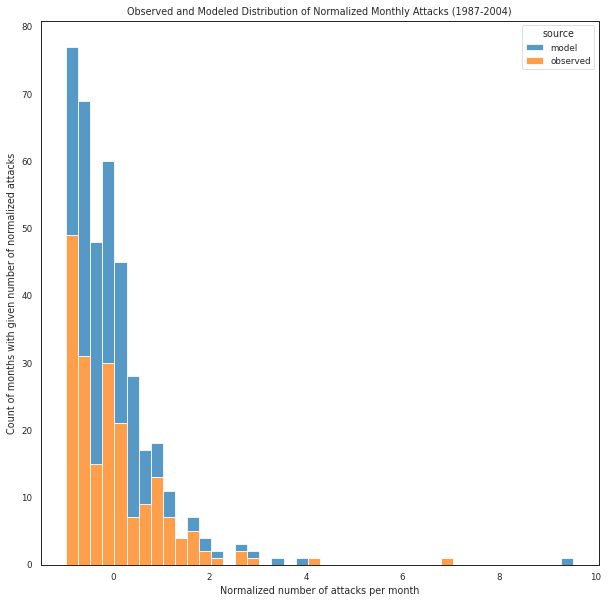

In [52]:
f, ax = plt.subplots(1,1,figsize=(10,10))

sns.histplot(viz_compare, multiple='stack',\
    x="attacks_norm",binwidth=0.25,
    hue='source')
ax.set_xlabel("Normalized number of attacks per month")
ax.set_ylabel("Count of months with given number of normalized attacks")
ax.set_title("Observed and Modeled Distribution of Normalized Monthly Attacks (1987-2004)")

In [57]:
model_params_cols = full_models.loc[:,('params','govt_policy','reactive_lvl','prob_violence','discontent','starting_population','steps')].drop_duplicates()
# confirm 1 row per param combo
print(len(param_combos))
print(model_params_cols.shape)
model_params_cols.head()

521
(521, 7)


params govt_policy reactive_lvl  \
697     (0.0001, 'NONE', 'low', 'mid', 300, 300)        NONE          low   
996     (0.0001, 'NONE', 'low', 'mid', 600, 200)        NONE          low   
1195    (0.0001, 'NONE', 'low', 'low', 300, 300)        NONE          low   
1494    (0.0001, 'NONE', 'low', 'low', 600, 200)        NONE          low   
1992  (0.0001, 'NONE', 'none', 'high', 300, 200)        NONE         none   

      prob_violence discontent  starting_population  steps  
697          0.0001        mid                  300    300  
996          0.0001        mid                  600    200  
1195         0.0001        low                  300    300  
1494         0.0001        low                  600    200  
1992         0.0001       high                  300    200

In [60]:
model_results_potential_matches = pd.merge(model_results_ks_good, model_params_cols, on=['params'])
print(model_results_potential_matches.shape)
model_results_potential_matches.head()

(9415, 12)


index dummy_date new_attacks                                     params  \
0      0 1988-01-31           6  (0.0001, 'NONE', 'none', 'low', 600, 200)   
1      2 1988-03-31           6  (0.0001, 'NONE', 'none', 'low', 600, 200)   
2      3 1988-04-30           2  (0.0001, 'NONE', 'none', 'low', 600, 200)   
3      4 1988-05-31           2  (0.0001, 'NONE', 'none', 'low', 600, 200)   
4      5 1988-06-30           1  (0.0001, 'NONE', 'none', 'low', 600, 200)   

   new_attacks_norm  param_id govt_policy reactive_lvl  prob_violence  \
0         -0.382573         1        NONE         none         0.0001   
1         -0.382573         1        NONE         none         0.0001   
2         -0.747545         1        NONE         none         0.0001   
3         -0.747545         1        NONE         none         0.0001   
4         -0.838788         1        NONE         none         0.0001   

  discontent  starting_population  steps  
0        low                  600    200  
1        low                  600    200  
2        low                  600    200  
3        low                  600    200  
4        low                  600    200

In [61]:
# consider breakdown of 47 'good' simulations according to their parameters
print(
    """
    Probability of violence: 
    {}
    Government policy: 
    {}
    Reactive Level: 
    {}
    Discontent: 
    {}
    """.format(
        model_results_potential_matches.\
            groupby('prob_violence')['param_id'].nunique(),
        model_results_potential_matches.\
            groupby('govt_policy')['param_id'].nunique(),
        model_results_potential_matches.\
            groupby('reactive_lvl')['param_id'].nunique(),
        model_results_potential_matches.\
            groupby('discontent')['param_id'].nunique()
    )
)


    Probability of violence: 
    prob_violence
0.0001     7
0.0005     4
0.0010     6
0.0030     7
0.0050     6
0.0100    17
Name: param_id, dtype: int64
    Government policy: 
    govt_policy
CONC    14
NONE    16
REPR    17
Name: param_id, dtype: int64
    Reactive Level: 
    reactive_lvl
none    47
Name: param_id, dtype: int64
    Discontent: 
    discontent
high    14
low     20
mid     13
Name: param_id, dtype: int64
    


#### References  
  
https://stackoverflow.com/questions/2013124/regex-matching-up-to-the-first-occurrence-of-a-character  